### 8.1 sklearn中使用决策树

In [4]:
%matplotlib inline

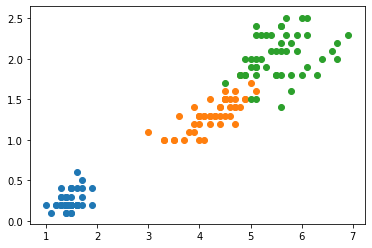

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,2:] # iris有四个特征，这里取后两个，形成一个坐标点
y = iris.target
# 绘图
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==2,0],X[y==2,1])
plt.show()

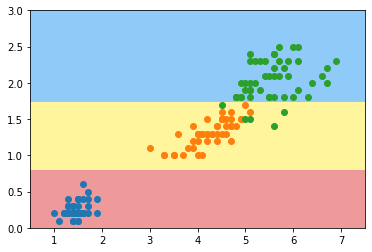

In [9]:
from sklearn.tree import DecisionTreeClassifier
# 创建决策树对象，最大深度max_depth为2层，criterion评判标准为entropy（熵）
dt_clt = DecisionTreeClassifier(max_depth=2,criterion='entropy')
# 将训练数据送给模型
dt_clt.fit(X,y)

# 绘制决策边界
def plot_decision_boundary(model, axis): # model是模型，axis是范围
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1],int((axis[1]-axis[0])*100)).reshape(-1,1),
        np.linspace(axis[2], axis[3],int((axis[3]-axis[2])*100)).reshape(-1,1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

# 数据可视化    
plot_decision_boundary(dt_clt, axis=[0.5,7.5,0,3])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==2,0],X[y==2,1])
plt.show()

### 8.2 特征选择中的相关概念

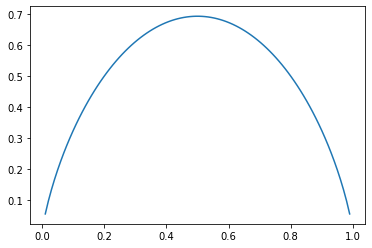

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# p可以传递数值，也可以传递向量。因此使用np.log
def entropy(p):
    return -p * np.log(p) - (1-p) * np.log(1-p)
    
# linspace生成向量x，从0到1均匀取值，绘制出x在不同值时对应的信息熵
x = np.linspace(0.01,0.99,100)

plt.plot(x,entropy(x))
plt.show()

### 8.3 特征选择之寻找最优划分

In [12]:
import numpy as np
from collections import Counter
from math import log

# 每列：['年龄','有工作','有自己的房子','信贷情况','是否申请贷款']
dataSet=np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 1, 0, 1, 1],
                  [0, 1, 1, 0, 1],
                  [0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0],
                  [1, 0, 0, 1, 0],
                  [1, 1, 1, 1, 1],
                  [1, 0, 1, 2, 1],
                  [1, 0, 1, 2, 1],
                  [2, 0, 1, 2, 1],
                  [2, 0, 1, 1, 1],
                  [2, 1, 0, 1, 1],
                  [2, 1, 0, 2, 1],
                  [2, 0, 0, 0, 0]])
featList = ['年龄','有工作','有自己的房子','信贷情况']

"""
函数说明：计算给定标签的经验熵（信息熵）
Parameters：
    y：使用标签y计算信息熵，，此时传递y是多维数组
    计算信息熵需要每种类别出现的概率p，因此传入包含分类信息的标签y
Returns：
    entropy：经验熵
"""
def calEntropy(y):
    # 计数器，统计y中所有类别出现的次数
    # 扁平化，将嵌套的多维数组变成一维数组
    counter = Counter(y.flatten())
    entropy = 0
    for num in counter.values():
        p = num / len(y)
        entropy += -p * log(p)
    return entropy

"""
函数说明：根据传递进来的特征维度及值，将数据划分为2类
Parameters：
    X,y,featVec,value：特征向量、标签、特征维度、值
Returns：
    返回划分为两类的后的数据
"""
def split(X, y, featVec, value):
    # 使用维度featVect上的value，将数据划分成左右两部分
    # 得到的布尔向量，传入array中做索引，即可找出满足条件的相应数据（布尔屏蔽）
    index_a = (X[:,featVec] <= value)
    index_b = (X[:,featVec] > value)
    return X[index_a], X[index_b], y[index_a], y[index_b]
    

"""
函数说明：寻找最优划分
Parameters：
    X,y：特征向量、标签
Returns：
    返回最优熵，以及在哪个维度、哪个值进行划分
"""
def try_split(X, y):
    # 搞一个熵的初始值：正无穷
    best_entropy = float('inf')
    best_featVec = -1    # 特征向量
    best_value = -1
    # 遍历每一个特征维度（列）
    for featVec in range(X.shape[1]):
        # 然后需要找到每个特征维度上的划分点。
        # 找出该维度上的每个两个样本点的中间值，作为候选划分点。
        # 为了方便寻找候选划分点，可以对该维度上的数值进行排序，
        # argsort函数返回的是数组值从小到大的索引值（不打乱原来的顺序）
        sort_index = np.argsort(X[:,featVec])        
        for i in range(1, len(X)):
            if X[sort_index[i-1], featVec] != X[sort_index[i], featVec]:
                value = (X[sort_index[i-1], featVec] + X[sort_index[i], featVec]) / 2
                X_l, X_r, y_l, y_r = split(X, y, featVec, value)
                # 要求最优划分，需要看在此划分下得到的两个分类数据集的熵之和是否是最小的
                entropy = calEntropy(y_l) + calEntropy(y_r)
                if entropy < best_entropy:
                    best_entropy, best_featVec, best_value = entropy, featVec, value
    return best_entropy, best_featVec, best_value      
    
best_entropy, best_featVec, best_value = try_split(X, y)
print("最优熵：", best_featVec)
print("在哪个维度熵进行划分：", best_featVec)
print("在哪个值上进行划分：", best_value)

最优熵： 0
在哪个维度熵进行划分： 0
在哪个值上进行划分： 2.45


In [13]:
import numpy as np
from collections import Counter
from math import log

# 每列：['年龄','有工作','有自己的房子','信贷情况','是否申请贷款']，其中'是否申请贷款'是label
dataSet=np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 1, 0, 1, 1],
                  [0, 1, 1, 0, 1],
                  [0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0],
                  [1, 0, 0, 1, 0],
                  [1, 1, 1, 1, 1],
                  [1, 0, 1, 2, 1],
                  [1, 0, 1, 2, 1],
                  [2, 0, 1, 2, 1],
                  [2, 0, 1, 1, 1],
                  [2, 1, 0, 1, 1],
                  [2, 1, 0, 2, 1],
                  [2, 0, 0, 0, 0]])
X = dataSet[:,:4]
y = dataSet[:,-1:]
strs = ['年龄','有工作','有自己的房子','信贷情况','是否申请贷款']


"""
函数说明：计算经验熵
Parameters：
    dataSet：样本数据集D
Returns：
    entory：经验熵
"""
def calEntropy(dataSet):
    #返回数据集行数
    numEntries=len(dataSet)
    #保存每个标签（label）出现次数的字典：<label:出现次数>
    labelCounts={}
    #对每组特征向量进行统计
    for featVec in dataSet:
        #提取标签信息
        currentLabel=featVec[-1]
        #如果标签没有放入统计次数的字典，添加进去
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        #label计数
        labelCounts[currentLabel]+=1
    
    entory=0.0
    #计算经验熵
    for key in labelCounts:
        #选择该标签的概率
        prob=float(labelCounts[key])/numEntries 
        #利用公式计算
        entory-=prob*log(prob,2)
    return entory 


"""
函数说明：得到当前特征条件下的小类的所有样本集合（即不包含当前特征的特征样本集）
Parameters：
    dataSet：样本数据集D
    curtFeatIndex：当前用来划分数据集的特征A的位置
    categories：特征A所有可能分类的集合
Returns：
    otherFeatSets：不包含当前特征的特征样本集
"""
def currentConditionSet(dataSet, curtFeatIndex, categroy):
    otherFeatSets = []
    # 对于数据集中的所有特征向量，抛去当前特征后拼接好的集合
    for featVec in dataSet:
        if featVec[curtFeatIndex] == categroy:
            otherFeatSet = np.append(featVec[:curtFeatIndex],featVec[curtFeatIndex+1:])
            otherFeatSets.append(otherFeatSet) 
    return otherFeatSets


"""
函数说明：在选择当前特征的条件下，计算熵，即条件熵
Parameters：
    dataSet：样本数据集D
    curtFeatIndex：当前用来划分数据集的特征A的位置
    categories：特征A所有可能分类的集合
Returns：
    conditionalEnt：返回条件熵
"""
def calConditionalEnt(dataSet, curtFeatIndex, categories):
    conditionalEnt = 0
    # 对于每一个分类，计算选择当前特征的条件下条件熵
    # 比如在选择“年龄”这一特征下，共有“老中青”三个小分类
    for categroy in categories:
        # 得到当前特征条件下的小类的所有样本集合，即不包含当前特征的特征样本集
        # 如得到在选择“青年”这个小类下一共有5个样本，且不包含“年龄”这一特征
        cdtSetCategroy = currentConditionSet(dataSet, curtFeatIndex, categroy)
        # 计算当前特征条件下的小分类，占总分类的比例
        prob = len(cdtSetCategroy) / float(dataSet.shape[0])
        # 累加得到条件熵
        conditionalEnt += prob * calEntropy(cdtSetCategroy)
    return conditionalEnt


"""
函数说明：计算信息增益
Parameters：
    baseEntropy：划分样本集合D的熵是为H(D)，即基本熵
    dataSet：样本数据集D
    curtFeatIndex：当前用来划分数据集的特征A的位置
Returns：
    infoGain：信息增益值
"""
def calInfoGain(baseEntropy,dataSet,curtFeatIndex):
    
    conditionalEnt = 0.0
    
    # categories是所有特征向量中当前特征的对应值的set集合（去重复）
    # 相当于该特征一共有几种分类，如“年龄”这一特征，分为“老中青”三类
    categories = set(dataSet[:,curtFeatIndex])
    
    # 计算划分后的数据子集（给定特征A的情况下，数据集D）的条件熵（经验条件熵）H(D|A)
    conditionalEnt = calConditionalEnt(dataSet,curtFeatIndex,categories)
    
    # 计算信息增益：g(D,A)=H(D)−H(D|A)
    infoGain = baseEntropy - conditionalEnt
    
    #打印每个特征的信息增益
    print("第%d个特征的增益为%.3f" % (curtFeatIndex, infoGain))
    return infoGain


"""
函数说明：寻找最优划分
Parameters：
    dataSet：数据集
Returns：
    打印最优划分结果
"""
def optimalPartition(dataSet):
    bestInfoGain = -1   # 最佳信息增益初始值
    bestFeatVec = -1    # 最佳划分的特征向量
    # 划分前样本集合D的熵H(D)，即基本熵
    baseEntropy = calEntropy(dataSet)
    
    # 遍历每一个特征维度（列），得到基于当前特征划分的信息增益
    for curtFeatIndex in range(dataSet.shape[1]-1):
        
        # 计算信息增益
        infoGain = calInfoGain(baseEntropy, dataSet, curtFeatIndex)
        
        # 选取最优信息增益的划分
        if (infoGain > bestInfoGain):
            #更新信息增益，找到最大的信息增益
            bestInfoGain = infoGain
            #记录信息增益最大的特征的索引值
            bestFeatVec = curtFeatIndex
    
    print("最佳的划分为第%d个特征，是”%s“，信息增益为%.3f" % (bestFeatVec,featList[bestFeatVec],bestInfoGain))
    return bestFeatVec     

optimalPartition(dataSet)

第0个特征的增益为0.083
第1个特征的增益为0.324
第2个特征的增益为0.420
第3个特征的增益为0.363
最佳的划分为第2个特征，是”有自己的房子“，信息增益为0.420


2

In [14]:
"""
函数说明：计算惩罚参数，信息增益g(D,A)与训练数据集D关于特征A的值的熵HA(D)之比
Parameters：
    dataSet：样本数据集D
    curtFeatIndex：当前用来划分数据集的特征A的位置
    categories：特征A所有可能分类的集合
Returns：
    conditionalEnt：惩罚参数
"""
def calPenaltyPara(dataSet, curtFeatIndex, categories):
    penaltyItem = 1
    # 对于每一个分类，计算选择当前特征的条件下条件熵
    # 比如在选择“年龄”这一特征下，共有“老中青”三个小分类
    for categroy in categories:
        # 得到当前特征条件下的小类的所有样本集合，即不包含当前特征的特征样本集
        # 如得到在选择“青年”这个小类下一共有5个样本，且不包含“年龄”这一特征
        cdtSetCategroy = currentConditionSet(dataSet, curtFeatIndex, categroy)
        # 计算当前特征条件下的小分类，占总分类的比例
        prob = len(cdtSetCategroy) / float(dataSet.shape[0])
        # 累加得到惩罚项
        penaltyItem += -prob * log(prob,2)
    return penaltyItem

"""
函数说明：计算信息增益率（惩罚参数 * 信息增益）
Parameters：
    baseEntropy：划分样本集合D的熵是为H(D)，即基本熵
    dataSet：样本数据集D
    curtFeatIndex：当前用来划分数据集的特征A的位置
Returns：
    infoGain：信息增益值
"""
def calInfoGainRate(baseEntropy,dataSet,curtFeatIndex):
    infoGainRate = 0.0
    # 计算信息增益
    infoGain = calInfoGain(baseEntropy,dataSet,curtFeatIndex)
    # 得到该特征的所有分类
    categories = set(dataSet[:,curtFeatIndex])
    # 计算惩罚项
    penaltyItem = calPenaltyPara(dataSet, curtFeatIndex, categories)
    # 计算信息增益率
    infoGainRatio = infoGain / penaltyItem
    
    #打印每个特征的信息增益率
    print("第%d个特征的增益率为%.3f" % (curtFeatIndex, infoGainRatio))
    return infoGainRatio

"""
函数说明：寻找最优划分
Parameters：
    dataSet：数据集
Returns：
    打印最优划分结果
"""
def optimalPartition(dataSet):
    bestInfoGainRatio = 0.0   # 最佳信息增益率初始值
    bestFeatVec = -1    # 最佳划分的特征向量
    # 划分前样本集合D的熵H(D)，即基本熵
    baseEntropy = calEntropy(dataSet)
    
    # 遍历每一个特征维度（列），得到基于当前特征划分的信息增益
    for curtFeatIndex in range(dataSet.shape[1]-1):
        
        # categories是所有特征向量中当前特征的对应值的set集合（去重复）
        # 相当于该特征一共有几种分类，如“年龄”这一特征，分为“老中青”三类
        #categories = set(dataSet[:,curtFeatIndex])
        
        # 计算信息增益率
        infoGainRatio = calInfoGainRate(baseEntropy, dataSet, curtFeatIndex)
        
        # 选取最优信息增益率的划分
        if (infoGainRatio > bestInfoGainRatio):
            #更新信息增益率，找到最大的信息增益率
            bestInfoGainRatio = infoGainRatio
            #记录信息增益率最大的特征的索引值
            bestFeatVec = curtFeatIndex
    
    print("最佳的划分为第%d个特征，是”%s“，信息增益率为%.3f" % (bestFeatVec,strs[bestFeatVec],bestInfoGainRatio))
    return     

optimalPartition(dataSet)

第0个特征的增益为0.083
第0个特征的增益率为0.032
第1个特征的增益为0.324
第1个特征的增益率为0.169
第2个特征的增益为0.420
第2个特征的增益率为0.213
第3个特征的增益为0.363
第3个特征的增益率为0.141
最佳的划分为第2个特征，是”有自己的房子“，信息增益率为0.213


In [15]:
"""
函数说明：计算基尼系数
Parameters：
    y：使用标签y计算信息熵，此时传递y是多维数组
Returns：
    entropy：经验熵
"""
def calGini(y):
    # 计数器，统计y中所有类别出现的次数
    # 扁平化，将嵌套的多维数组变成一维数组
    counter = Counter(y.flatten())
    gini = 1
    for num in counter.values():
        p = num / len(y)
        gini -= p ** 2
    return gini


"""
函数说明：寻找最优划分
Parameters：
    X,y：特征向量、标签
Returns：
    返回最优熵，以及在哪个维度、哪个值进行划分
"""
def try_split(X, y):
    # 搞一个基尼系数的初始值：正无穷
    bestGini = float('inf')
    bestFeatVec = -1    # 特征向量
    bestValue = -1
    # 遍历每一个特征维度（列）
    for featVec in range(X.shape[1]):
        # 然后需要找到每个特征维度上的划分点。
        # 找出该维度上的每个两个样本点的中间值，作为候选划分点。
        # 为了方便寻找候选划分点，可以对该维度上的数值进行排序，
        # argsort函数返回的是数组值从小到大的索引值（不打乱原来的顺序）
        sort_index = np.argsort(X[:,featVec])        
        for i in range(1, len(X)):
            if X[sort_index[i-1], featVec] != X[sort_index[i], featVec]:
                value = (X[sort_index[i-1], featVec] + X[sort_index[i], featVec]) / 2
                X_l, X_r, y_l, y_r = split(X, y, featVec, value)
                # 要求最优划分，需要看在此划分下得到的两个分类数据集的熵之和是否是最小的
                gini = calGini(y_l) + calGini(y_r)
                if gini < bestGini:
                    bestGini, bestFeatVec, bestValue = gini, featVec, value
    return bestGini, bestFeatVec, bestValue

bestGini, bestFeatVec, bestValue = try_split(X, y)
print("最优基尼系数：", bestGini)
print("在哪个维度上进行划分：", bestFeatVec)
print("在哪个值上进行划分：", bestValue)

最优基尼系数： 0.4444444444444445
在哪个维度上进行划分： 2
在哪个值上进行划分： 0.5


### 8.4 构建算法之ID3、C4.5

In [16]:
"""
函数说明：数据集已经处理了所有属性，但是类标签依然不是唯一的,采用多数判决的方法决定该子节点的分类
        即统计yList中出现次数最多的元素（类标签）
Parameters：
    yList：类标签列表
Returns：
    sortedClassCount[0][0]：出现次数最多的元素（类标签）
"""
def majorityCnt(yList):
    yCount={}
    #统计yList中每个元素出现的次数
    for vote in yList:
        if vote not in yCount.keys():
            yCount[vote]=0
        yCount[vote]+=1
        #根据字典的值降序排列
        sortedYCount=sorted(yCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedYCount[0][0]

"""
函数说明：创建决策树

Parameters:
    dataSet：训练数据集
    featList：分类属性标签
    bestFeatLists：存储选择的最优特征标签
Returns：
    myTree：决策树
"""
def createTree(dataSet,featList,bestFeatLists):
    # 取训练数据集最后一列，即分类标签
    yList=[example[-1] for example in dataSet]
    
    # 如果类别完全相同，则停止继续划分，
    # 即yList中所有类别都是同一数据值（该类别数值个数等于列表长度）
    if yList.count(yList[0])==len(yList):
        # 返回该类别数值
        return yList[0]
    
    
    # 数据集已经处理了所有属性，但是类标签依然不是唯一的，
    # 则采用多数判决的方法决定该子节点的分类
    # 为什么要如此判断？dataSet的列是不断减少的，dataSet某一行的长度，就是列
    if len(dataSet[0])==1:
        return majorityCnt(yList)
    
    # 选择最优划分的特征index
    bestFeatVec = optimalPartition(dataSet)
    # 最优特征index所对应的分类标签，作为树的根节点
    bestFeatLabel=featList[bestFeatVec]
    # 存储选择的最优特征标签
    bestFeatLists.append(bestFeatLabel)
    
    # 将最优划分特征值作为当前（子）树的根节点，生成初始决策树（用字典表示一个树结构）
    myTree={bestFeatLabel:{}}
    
    # 删除已经使用的特征标签（del删除变量，解除引用）
    # 因为每次选择特征作为条件，dataSet会删掉这一列，形成新的子类，因此对应的featList中的值也要删掉
    del(featList[bestFeatVec])
    print('featList: ',featList)
    
    
    # 得到训练集中所有最优特征那一列所对应的值
    featValues=[example[bestFeatVec] for example in dataSet]
    # 去掉重复的属性值，得到最优特征下的子类
    categories=set(featValues)
    
    # 遍历最优特征列所对应的值，创建决策树
    # 如“年龄”是最优特征，则遍历“老”“中”“青”三个子类
    for category in categories:
        # 根据当前数据集、最优划分的特征index以及每个分类（条件）得到（条件下的子集）
        subDataSet = np.array(currentConditionSet(dataSet,bestFeatVec,category))
        # 递归地调用创建决策树的方法，将递归调用的结果作为当前树节点的一个分支
        myTree[bestFeatLabel][category]=createTree(subDataSet,featList,bestFeatLists)
    return myTree

if __name__=='__main__':
    #print('featLabels',featLabels)
    bestFeatLists = []
    myTree=createTree(dataSet,featList,bestFeatLists)
    print(myTree)

第0个特征的增益为0.083
第0个特征的增益率为0.032
第1个特征的增益为0.324
第1个特征的增益率为0.169
第2个特征的增益为0.420
第2个特征的增益率为0.213
第3个特征的增益为0.363
第3个特征的增益率为0.141
最佳的划分为第2个特征，是”有自己的房子“，信息增益率为0.213


TypeError: list indices must be integers or slices, not NoneType

### 8.5 剪枝与sklearn中的决策树

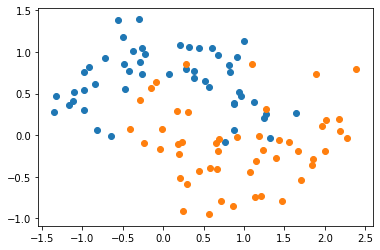

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X,y = datasets.make_moons(noise=0.25,random_state=666)

plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

In [18]:
def plot_decision_boundary(model, axis): # model是模型，axis是范围
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1],int((axis[1]-axis[0])*100)).reshape(-1,1),
        np.linspace(axis[2], axis[3],int((axis[3]-axis[2])*100)).reshape(-1,1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

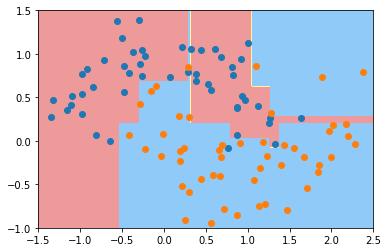

In [19]:
from sklearn.tree import DecisionTreeClassifier

# 如果在构建时不传参数，则默认是使用基尼系数进行特征划分
# 不限定max_depth，则决策树会一直向下划分，直到每一个节点的基尼系数为0为止
dt_clf1 = DecisionTreeClassifier()
dt_clf1.fit(X,y)
    
plot_decision_boundary(dt_clf1, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

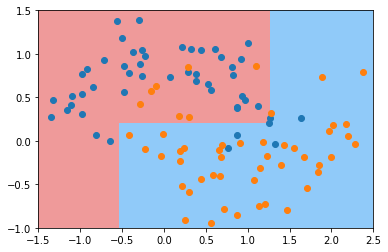

In [20]:
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X,y)

plot_decision_boundary(dt_clf2, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

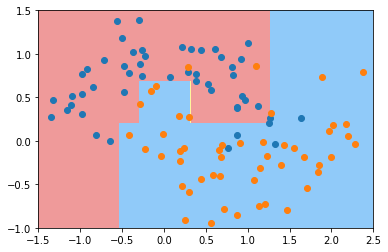

In [21]:
dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X,y)

plot_decision_boundary(dt_clf3, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

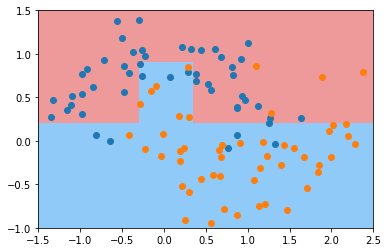

In [22]:
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X,y)

plot_decision_boundary(dt_clf4, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

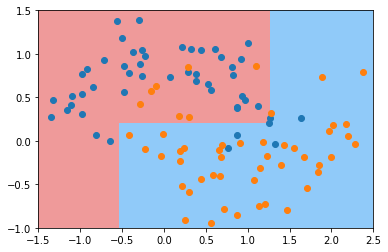

In [23]:
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=4)
dt_clf5.fit(X,y)

plot_decision_boundary(dt_clf5, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])
plt.show()

### 8.6 分类与回归树CART

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

boston = datasets.load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

dt_reg.score(X_test, y_test)

0.592872521513275